## Image Classification - One Node Training

In [1]:
# Importing Librairies
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, InputLayer, Reshape, Rescaling
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.utils import to_categorical
from keras.regularizers import l2
import matplotlib.pyplot as plt
import numpy as np
import os

# Uncomment next line to : Force using CPU only by making GPU invisible
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [32]:
# Importing & Preprocessing CIFAR-10 Dataset from Directory
img_height = 32
img_width = 32
trainval_path = 'C:/Users/PC/Desktop/DATASET/CIFAR-10/'
test_path = ''

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


def load_dataset():
    # Loading Training Dataset
    x_train = np.empty((50000, 32, 32, 3), dtype='uint8')
    y_train = np.empty((50000, ), dtype='uint8')
    i = 1    
    while i <= 5:
        filename = 'data_batch_' + str(i)
        fullpath = os.path.join(trainval_path, filename)
        data_batch = unpickle(fullpath)
        
        x = data_batch[b'data']
        x_train[(i - 1) * 10000:i * 10000, :, :, :] = x.reshape(len(x), 3, img_height, img_width).transpose(0, 2, 3, 1)
        y_train[(i - 1) * 10000:i * 10000] = data_batch[b'labels']
        i = i + 1
    
    # Loading Test/Validation Dataset
    fullpath = os.path.join(trainval_path, 'test_batch')
    data_batch = unpickle(fullpath)
    x_test = data_batch[b'data']
    x_test = x_test.reshape(len(x_test), 3, img_height, img_width).transpose(0, 2, 3, 1)
    y_test = data_batch[b'labels']
    y_test = np.asarray(y_test)
    
    # Normalizing Images
    x_train, x_test = normalize_images(x_train, x_test)
    # Display Dataset Size
    print('Training Images : {}'.format(len(x_train)))
    print('Test Images : {}'.format(len(x_test)))
    return (x_train, y_train), (x_test, y_test)



def normalize_images(train, test):
    # convert 0-255 integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # scaling values from 0-255 to 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm



'''TEST IF DATASET IS LOADED CORRECTLY'''
'''
(x_train, y_train), (x_test, y_test) = load_dataset()
print(x_test.shape)
plt.imshow(x_train[0])
plt.show()
'''

'\n(x_train, y_train), (x_test, y_test) = load_dataset()\nprint(x_test.shape)\nplt.imshow(x_train[0])\nplt.show()\n'

In [34]:
# Create and Compile Model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

model.compile(optimizer=optimizer, loss=loss_fn, metrics=[accuracy])
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_42 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_61 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_43 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                     

In [ ]:
# callbacks - variable learning rate

# callback - early stopping


In [35]:
# Training and Evaluating Model
# load CIFAR-10 Dataset
(x_train, y_train), (x_test, y_test) = load_dataset()
# Data Augmentation Generator
datagen = ImageDataGenerator(
            #rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True)
datagen.fit(x_train)
# Data iterator generating training batches
iter_train = datagen.flow(x_train, y_train, batch_size=64)
# Calculating Steps par Epoch
steps = int(len(x_train) / 64)
# Training the model
history = model.fit(iter_train, validation_data=(x_test, y_test), steps_per_epoch=steps, epochs=100)
#history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100)
score = model.evaluate(x_test, y_test)

Training Images : 50000
Test Images : 10000
Epoch 1/100
781/781 [==============================] - 22s 26ms/step - loss: 1.9010 - sparse_categorical_accuracy: 0.3552 - val_loss: 1.7111 - val_sparse_categorical_accuracy: 0.4385
Epoch 2/100
781/781 [==============================] - 20s 26ms/step - loss: 1.3628 - sparse_categorical_accuracy: 0.5068 - val_loss: 1.6077 - val_sparse_categorical_accuracy: 0.4882
Epoch 3/100
781/781 [==============================] - 20s 26ms/step - loss: 1.1738 - sparse_categorical_accuracy: 0.5778 - val_loss: 1.3204 - val_sparse_categorical_accuracy: 0.5759
Epoch 4/100
781/781 [==============================] - 20s 26ms/step - loss: 1.0431 - sparse_categorical_accuracy: 0.6315 - val_loss: 1.0291 - val_sparse_categorical_accuracy: 0.6490
Epoch 5/100
781/781 [==============================] - 22s 28ms/step - loss: 0.9520 - sparse_categorical_accuracy: 0.6660 - val_loss: 1.0011 - val_sparse_categorical_accuracy: 0.6692
Epoch 6/100
781/781 [====================

781/781 [==============================] - 22s 28ms/step - loss: 0.4358 - sparse_categorical_accuracy: 0.8493 - val_loss: 0.4954 - val_sparse_categorical_accuracy: 0.8316
Epoch 46/100
781/781 [==============================] - 20s 26ms/step - loss: 0.4286 - sparse_categorical_accuracy: 0.8523 - val_loss: 0.4713 - val_sparse_categorical_accuracy: 0.8446
Epoch 47/100
781/781 [==============================] - 20s 25ms/step - loss: 0.4254 - sparse_categorical_accuracy: 0.8543 - val_loss: 0.3937 - val_sparse_categorical_accuracy: 0.8656
Epoch 48/100
781/781 [==============================] - 20s 25ms/step - loss: 0.4181 - sparse_categorical_accuracy: 0.8559 - val_loss: 0.3999 - val_sparse_categorical_accuracy: 0.8646
Epoch 49/100
781/781 [==============================] - 21s 27ms/step - loss: 0.4198 - sparse_categorical_accuracy: 0.8541 - val_loss: 0.4250 - val_sparse_categorical_accuracy: 0.8592
Epoch 50/100
781/781 [==============================] - 22s 28ms/step - loss: 0.4163 - sparse

781/781 [==============================] - 21s 26ms/step - loss: 0.3573 - sparse_categorical_accuracy: 0.8768 - val_loss: 0.3550 - val_sparse_categorical_accuracy: 0.8809
Epoch 90/100
781/781 [==============================] - 20s 25ms/step - loss: 0.3564 - sparse_categorical_accuracy: 0.8773 - val_loss: 0.4699 - val_sparse_categorical_accuracy: 0.8484
Epoch 91/100
781/781 [==============================] - 20s 25ms/step - loss: 0.3552 - sparse_categorical_accuracy: 0.8773 - val_loss: 0.4186 - val_sparse_categorical_accuracy: 0.8640
Epoch 92/100
781/781 [==============================] - 20s 26ms/step - loss: 0.3512 - sparse_categorical_accuracy: 0.8778 - val_loss: 0.3669 - val_sparse_categorical_accuracy: 0.8776
Epoch 93/100
781/781 [==============================] - 21s 27ms/step - loss: 0.3512 - sparse_categorical_accuracy: 0.8775 - val_loss: 0.3651 - val_sparse_categorical_accuracy: 0.8802
Epoch 94/100
781/781 [==============================] - 20s 25ms/step - loss: 0.3505 - sparse

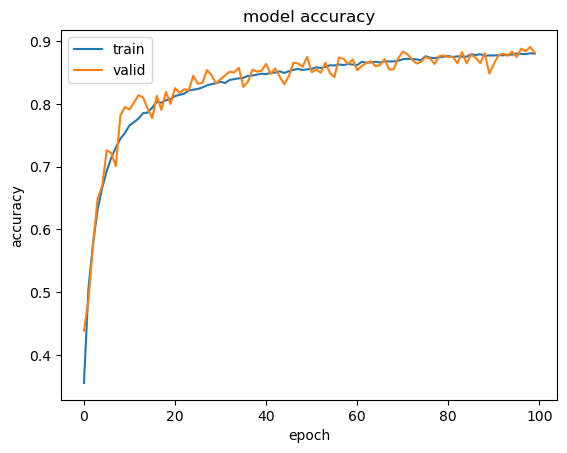

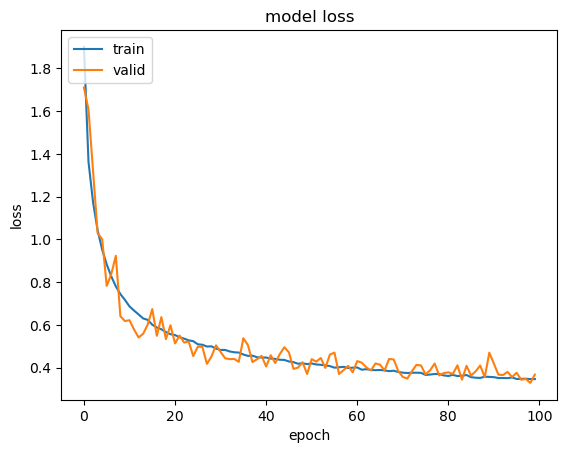

In [36]:
# plot training and validation accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()